--- Data Information and Checks (EDA) ---
DataFrame Shape: (9551, 21)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null 

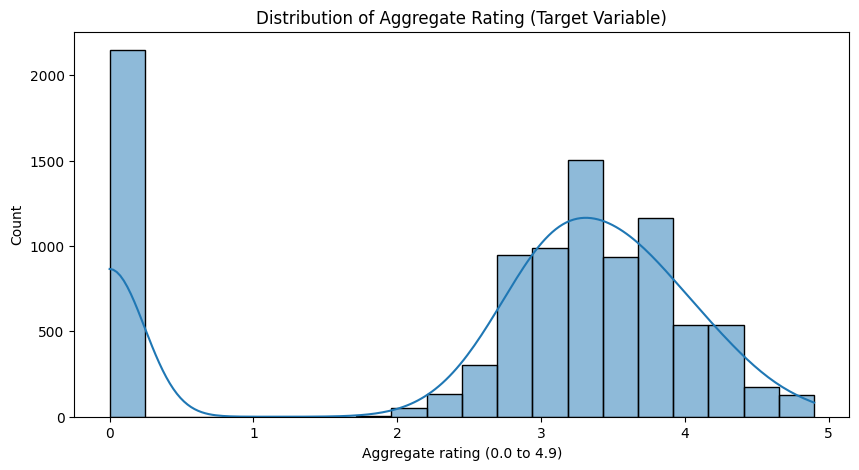

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the cleaned dataset from pre task
df = pd.read_csv("cleaned_dataset.csv")

# Basic Data Checks (EDA)
print("--- Data Information and Checks (EDA) ---")
print(f"DataFrame Shape: {df.shape}")
print("\nDataFrame Info:")
df.info()

print("\nMissing Value Count (Should be zero for key columns):")
print(df.isnull().sum())

print("\nDescriptive Statistics (Numerical):")
print(df.describe())

# Target Variable Visualization (Crucial for a Regression Task)
plt.figure(figsize=(10, 5))
sns.histplot(df['Aggregate rating'], kde=True, bins=20)
plt.title('Distribution of Aggregate Rating (Target Variable)')
plt.xlabel('Aggregate rating (0.0 to 4.9)')
plt.show()

In [2]:
# Mapping Country Codes to Names
country_codes = {1: 'India', 14: 'Australia', 30: 'Brazil', 37: 'Canada', 94: 'Indonesia', 162: 'Philippines', 184: 'Singapore', 189: 'South Africa', 191: 'Sri Lanka', 208: 'Turkey', 214: 'UAE', 215: 'United Kingdom', 216: 'United States'}
df['Country'] = df['Country Code'].map(country_codes)

# Separate the Target (Y) from the Features (X)
Y = df['Aggregate rating']
X = df[['Votes', 'Average Cost for two', 'Price range', 'Cuisines', 'Country', 'Has Table booking', 'Has Online delivery']].copy()

In [4]:
# ENCODING FOR CUISINES(Binary Flag Encoding for 'Cuisines')
all_cuisines_list = df['Cuisines'].str.split(', ').explode().str.strip()
# Selecting the names of the 20 most frequent cuisines
top_cuisines = all_cuisines_list.value_counts().head(20).index.tolist()
# Creating the 20 Binary Flag columns (the Checklist)
print(f"Creating {len(top_cuisines)} binary cuisine features (0/1)...")
for cuisine in top_cuisines:
  # Column Creation and Value Assignment
  X.loc[:, cuisine] = df['Cuisines'].apply(lambda x: 1 if cuisine in str(x) else 0)
# Removing the original Cuisines column
X = X.drop(columns=['Cuisines'])

Creating 20 binary cuisine features (0/1)...


In [5]:
# Assuming X (with 20 cuisine flags, Country, Has Table booking, Has Online delivery, Votes, Average Cost for two , Price range) and Y are defined.

# Data Splitting: 80% Train, 20% Test (0.2)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
# Target Encoding for 'Country'
# Calculating means only on the training data (Y_train)
country_mean_map = Y_train.groupby(X_train['Country']).mean()

# Applying the mapping
X_train.loc[:, 'Country_Target_Encoded'] = X_train['Country'].map(country_mean_map)
X_test.loc[:, 'Country_Target_Encoded'] = X_test['Country'].map(country_mean_map)

# Handling NaNs in testing data with global mean
global_mean = Y_train.mean()
X_test.loc[:, 'Country_Target_Encoded'] = X_test.loc[:, 'Country_Target_Encoded'].fillna(global_mean)

# Dropping original 'Country' column from both training and testing data
X_train = X_train.drop(columns=['Country'])
X_test = X_test.drop(columns=['Country'])

In [7]:
# One-Hot Encoding for features 'Has Table Booking' and 'Has Online delivery'
X_train = pd.get_dummies(X_train, columns=['Has Table booking', 'Has Online delivery'], drop_first=True)
X_test= pd.get_dummies(X_test, columns=['Has Table booking','Has Online delivery'], drop_first=True)

# Allignment (Ensuring X_test has the exact same columns as X_train)
X_train_final=X_train.copy()
X_test_clean=X_test.copy()

missing_cols=set(X_train_final.columns)-set(X_test_clean.columns)
for c in missing_cols:
  X_test_clean[c]= 0
X_test_final= X_test_clean[X_train_final.columns]


In [9]:
#Model Loading
model= LinearRegression()

# Impute NaN values in X_train_final and X_test_final with the mean of the training data
# Calculate column means from X_train_final
for col in X_train_final.columns:
    if X_train_final[col].isnull().any():
        mean_value = X_train_final[col].mean()
        X_train_final[col] = X_train_final[col].fillna(mean_value)
        X_test_final[col] = X_test_final[col].fillna(mean_value)

# Training
model.fit(X_train_final, Y_train)
#Predicing
Y_pred= model.predict(X_test_final)

# Evaluation
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)


In [10]:
# MODEL EVALUATION
print("Root Mean Squared Error (RMSE):", round(rmse, 4))
print("R-squared (R2) Score:", round(r2, 4))

Root Mean Squared Error (RMSE): 1.2393
R-squared (R2) Score: 0.3252


In [11]:
# FEATURE INFLUENCE ANALYSIS
# Create a DataFrame of coefficients for analysis
coefficients = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': model.coef_
})

# Calculating the absolute magnitude for sorting influence
coefficients['Absolute_Coefficient'] = coefficients['Coefficient'].abs()

# Sort by influence (absolute magnitude)
coefficients_sorted = coefficients.sort_values(by='Absolute_Coefficient', ascending=False)

# Print the top 5 most influential positive and negative features
print("FEATURE INFLUENCE ANALYSIS (TOP 10 COEFFICIENTS)")

# Top 5 POSITIVE (largest positive coefficient)
top_5_positive = coefficients_sorted.nlargest(5, 'Coefficient')
print("\nTop 5 POSITIVE Influencers:")
print(top_5_positive[['Feature', 'Coefficient']].round(4))

# Top 5 NEGATIVE (largest negative coefficient)
top_5_negative = coefficients_sorted.nsmallest(5, 'Coefficient')
print("\nTop 5 NEGATIVE Influencers:")
print(top_5_negative[['Feature', 'Coefficient']].round(4))

FEATURE INFLUENCE ANALYSIS (TOP 10 COEFFICIENTS)

Top 5 POSITIVE Influencers:
                    Feature  Coefficient
23   Country_Target_Encoded       0.7858
25  Has Online delivery_Yes       0.7420
2               Price range       0.5162
10                     Cafe       0.4587
11                 Desserts       0.3940

Top 5 NEGATIVE Influencers:
                 Feature  Coefficient
16                Mithai      -0.0691
3           North Indian      -0.0634
15                 Pizza      -0.0360
1   Average Cost for two      -0.0000
0                  Votes       0.0006
